# Feature selection

In [1]:
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

data_path = os.getenv('TRAINING_DATA')
df_train = pd.read_csv(data_path)
df_train = df_train.drop(columns = 'Studio')

df_train.columns

Index(['Sesso', 'Diabete', 'ESRD', 'Eta1', 'Prot1', 'Creat1', 'Epi1',
       'Colesterolo1', 'Hb1', 'Ca1', 'P1', 'BMI1', 'ckd_cause_hypertens',
       'ckd_cause_diabet', 'ckd_cause_glom_dis', 'ckd_cause_tubul_inter',
       'ckd_cause_pkd', 'esrd_upper', 'esrd_lower'],
      dtype='object')

In [2]:
df_train.shape

(3599, 19)

### Data exploration

<Axes: xlabel='esrd_lower', ylabel='Count'>

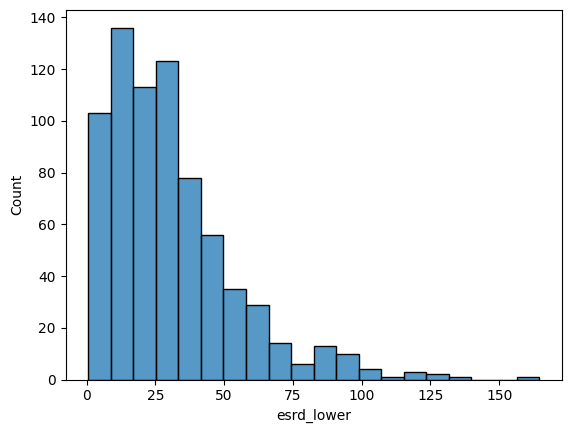

In [3]:
import seaborn as sns
import math

sns.histplot(data=df_train.query('ESRD==1'), x="esrd_lower", bins=20)

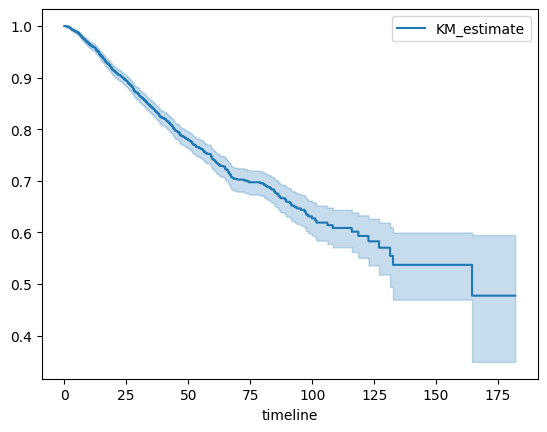

In [4]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Visualize the survival distribution
kmf = KaplanMeierFitter()
kmf.fit(durations=df_train['esrd_lower'], event_observed=df_train['ESRD'])
kmf.plot_survival_function()
plt.show()

### Further preprocess the data

In [5]:
df_train.columns

Index(['Sesso', 'Diabete', 'ESRD', 'Eta1', 'Prot1', 'Creat1', 'Epi1',
       'Colesterolo1', 'Hb1', 'Ca1', 'P1', 'BMI1', 'ckd_cause_hypertens',
       'ckd_cause_diabet', 'ckd_cause_glom_dis', 'ckd_cause_tubul_inter',
       'ckd_cause_pkd', 'esrd_upper', 'esrd_lower'],
      dtype='object')

In [6]:
# Also remove creatinine as it is redundant with eGFR
df_train = df_train.drop(columns = ['ESRD', 'Creat1'])
print(df_train.columns)

Index(['Sesso', 'Diabete', 'Eta1', 'Prot1', 'Epi1', 'Colesterolo1', 'Hb1',
       'Ca1', 'P1', 'BMI1', 'ckd_cause_hypertens', 'ckd_cause_diabet',
       'ckd_cause_glom_dis', 'ckd_cause_tubul_inter', 'ckd_cause_pkd',
       'esrd_upper', 'esrd_lower'],
      dtype='object')


In [7]:
print(df_train.shape)

(3599, 17)


In [8]:
labelcols = {
    'lower': 'esrd_lower',
    'upper': 'esrd_upper'
}

### Feature selection and hyperparameter tuning

In [9]:
# Define the default hyperparameters

xgbparams = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'extreme',
    'aft_loss_distribution_scale': 0.1,
    'tree_method': 'hist', 
    'learning_rate': 0.01, 
    'max_depth': [8,10], 
    'booster':'gbtree',
    'subsample':1.0,
    'min_child_weight': 1.0,
    'colsample_bynode':1.0,
    'verbosity':1,
    'n_models': 30,
    'subset_fraction': (1.0, 3.0)
}

In [10]:
import bagging
import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
import lifelines
from itertools import product
from sklearn.metrics import mean_absolute_error

# SHAP value based feature selection 5 times

n_splits = 5
random_states = [1, 35, 10]

for random_state in random_states:
    print('-----------------\nrandom state: ' + str(random_state) + ' \n')
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    c_indices = []
    shap_df = pd.DataFrame(list(), columns = df_train.columns).drop(columns=labelcols.values())
    
    for i, (train_idx, test_idx) in enumerate(kf.split(df_train)):
        train_fold = df_train.iloc[train_idx]
        test_fold = df_train.iloc[test_idx]
        # Initiate the model and train on train_fold
        model_feature_select = bagging.BaggingXGBRegressor(params=xgbparams, labelcols=labelcols)
        model_feature_select.train(train_fold, early_stopping_rounds=150, num_boost_round=1500, verbose_eval=None)
        # Calculate the shap values on the training part of the fold and add it to shap_df
        shap_vals = model_feature_select.feature_importances('shap', df = train_fold)
        shap_val_average = np.mean(np.array([ s.shap_values(train_fold.drop(columns=labelcols.values())) for s in shap_vals ]), axis=0)
        shap_val_average_abs = np.abs(shap_val_average)
        shap_df.loc[i] = np.mean(shap_val_average_abs, axis = 0)
        # Calculate the c-index in test_fold
        pred = np.round(np.mean(model_feature_select.predict(test_fold, output_margin = False), axis = 0), 2)
        event_times = test_fold['esrd_lower'].to_numpy()
        event_observed = (test_fold['esrd_upper'] == test_fold['esrd_lower']).astype(int).to_numpy()
        print('Median of time to ESRD development: ' + str(round(np.median(event_times[np.where(event_observed == 1)]), 1)) + 
              '. Median of predicted time to ESRD development: ' + str(round(np.median(pred[np.where(event_observed == 1)]), 1)))
        print('MAE: ' + str(round(mean_absolute_error(event_times[np.where(event_observed == 1)], pred[np.where(event_observed == 1)]), 1)))
        print('Median time for censored cases: ' + str(round(np.median(event_times[np.where(event_observed == 0)]), 1)) + 
          '. Median time predicted for censored cases: ' + str(round(np.median(pred[np.where(event_observed == 0)]), 1)))
        c_index = lifelines.utils.concordance_index(event_times, pred, event_observed)
        c_indices.append(c_index)
        # Print progress
        print('Iter ' + str(i+1))
        print('C-index: ' + str(round(c_index, 3)) + '\n')
        
    if random_states.index(random_state) == 0:
        shap_df_averages = pd.DataFrame()
        shap_df_averages[str(random_state)] = pd.DataFrame(np.mean(shap_df, axis = 0))
    else:
        shap_df_averages[str(random_state)] = pd.DataFrame(np.mean(shap_df, axis = 0))

    print('The C index with all variables is: '+ str(round(np.mean(c_indices), 3)) + '±' + str(round(np.std(c_indices), 3)) + '\n\n')

/Users/tamasszili-torok/Research/machine_learning/ESKD-predict/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----------------
random state: 1 

Median of time to ESRD development: 25.5. Median of predicted time to ESRD development: 39.4
MAE: 21.3
Median time for censored cases: 40.2. Median time predicted for censored cases: 93.1
Iter 1
C-index: 0.866

Median of time to ESRD development: 26.7. Median of predicted time to ESRD development: 33.0
MAE: 22.5
Median time for censored cases: 38.5. Median time predicted for censored cases: 97.0
Iter 2
C-index: 0.858

Median of time to ESRD development: 27.9. Median of predicted time to ESRD development: 36.6
MAE: 21.0
Median time for censored cases: 38.2. Median time predicted for censored cases: 96.4
Iter 3
C-index: 0.867

Median of time to ESRD development: 25.7. Median of predicted time to ESRD development: 35.2
MAE: 23.0
Median time for censored cases: 37.7. Median time predicted for censored cases: 92.9
Iter 4
C-index: 0.876

Median of time to ESRD development: 23.8. Median of predicted time to ESRD development: 36.5
MAE: 22.7
Median time for c

In [11]:
shap_df_averages['mean'] = shap_df_averages.mean(axis=1)

In [12]:
all_features_ranked = shap_df_averages['mean'].sort_values(ascending = False).index
all_features_ranked

Index(['Epi1', 'Prot1', 'BMI1', 'Eta1', 'P1', 'Ca1', 'Hb1', 'Colesterolo1',
       'ckd_cause_hypertens', 'Sesso', 'Diabete', 'ckd_cause_pkd',
       'ckd_cause_tubul_inter', 'ckd_cause_glom_dis', 'ckd_cause_diabet'],
      dtype='object')

In [13]:
def bagging_grid_search(df, params, features, random_states, labelcols):

    param_combinations = list(product(*params.values()))
    df_result = pd.DataFrame()
    best_c_index = 0.5
    for random_state in random_states:
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        for i, param_combo in enumerate(param_combinations):
            current_params = dict(zip(params.keys(), param_combo))
        
            current_params = {
                'objective': current_params.get('objective', 'survival:aft'),
                'eval_metric': current_params.get('eval_metric', 'aft-nloglik'),
                'aft_loss_distribution': current_params.get('aft_loss_distribution', 'normal'),
                'aft_loss_distribution_scale': current_params.get('aft_loss_distribution_scale', '1.2'),
                'tree_method': current_params.get('tree_method', 'hist'), 
                'learning_rate': current_params.get('learning_rate', 0.01), 
                'max_depth': current_params.get('max_depth', [8,10]), 
                'booster':current_params.get('booster', 'gbtree'),
                'subsample': current_params.get('subsample', 1.0),
                'min_child_weight': current_params.get('min_child_weight', 1.0),
                'colsample_bynode': current_params.get('colsample_bynode', 1.0),
                'n_models': current_params.get('n_models', 30),
                'subset_fraction': current_params.get('subset_fraction', 1.0)
            }
        
            c_indices = []
        
            for train_idx, test_idx in kf.split(df):
                df_train_split = df[features]
                model = bagging.BaggingXGBRegressor(params=current_params, labelcols=labelcols)
                model.train(df_train_split.iloc[train_idx], early_stopping_rounds=150, num_boost_round=1500, verbose_eval=None)
            
                pred = np.round(np.mean(model.predict(df_train_split.iloc[test_idx], output_margin = False), axis = 0), 2)
                event_times = df_train_split.iloc[test_idx]['esrd_lower'].to_numpy()
                event_observed = (df_train_split.iloc[test_idx]['esrd_upper'] == df_train_split.iloc[test_idx]['esrd_lower']).astype(int).to_numpy()
            
                c_indices.append(lifelines.utils.concordance_index(event_times, pred, event_observed))
        
            df_result.loc[str(i), str(random_state)] = np.mean(c_indices)

    df_result['mean'] = df_result.mean(axis=1)
    max_index = df_result['mean'].idxmax()
    best_c_index = df_result.loc[max_index, 'mean']
    best_params = param_combinations[int(max_index)]
    
    return best_params, best_c_index, df_result, param_combinations

In [14]:
var_dict = {'feat' : [],
            'c_index': [],
            'sd': [],
            'best_hyperparams': [],
            'df_result': [],
            'param_combinations': []}

params = {'aft_loss_distribution': ['extreme'],
          'aft_loss_distribution_scale': [0.1],
          'max_depth': [[8,10]],
          'n_models': [30, 50],
          'subset_fraction': [(1.0, 3.0)]} 

random_states_3 = [1, 35, 10]

for i, feature in enumerate(all_features_ranked):
    
    features_to_train_current_iter = all_features_ranked[:(i+1)]
    features_to_train_current_iter = np.append(features_to_train_current_iter, np.array([labelcols['lower'], labelcols['upper']]))
    
    best_params_, best_c_index_, df_result_, param_combinations_ = bagging_grid_search(df_train, params, features_to_train_current_iter, 
                                                                                    random_states_3, labelcols)
        
    var_dict['feat'].append(feature)
    var_dict['c_index'].append(best_c_index_)
    var_dict['best_hyperparams'].append(best_params_)
    var_dict['df_result'].append(df_result_)
    var_dict['param_combinations'].append(param_combinations_)
    print('')
    print('----------\nModel with adding feature ' + feature + ' has a c index of ' + str(round(best_c_index_, 3)))
    print('Best params: ' + str(best_params_))
    print('progress: ' + str(i+1) + ' out of ' + str(len(all_features_ranked)) + '\n\n')


----------
Model with adding feature Epi1 has a c index of 0.83
Best params: ('extreme', 0.1, [8, 10], 50, (1.0, 3.0))
progress: 1 out of 15



----------
Model with adding feature Prot1 has a c index of 0.844
Best params: ('extreme', 0.1, [8, 10], 50, (1.0, 3.0))
progress: 2 out of 15



----------
Model with adding feature BMI1 has a c index of 0.856
Best params: ('extreme', 0.1, [8, 10], 50, (1.0, 3.0))
progress: 3 out of 15



----------
Model with adding feature Eta1 has a c index of 0.861
Best params: ('extreme', 0.1, [8, 10], 50, (1.0, 3.0))
progress: 4 out of 15



----------
Model with adding feature P1 has a c index of 0.863
Best params: ('extreme', 0.1, [8, 10], 50, (1.0, 3.0))
progress: 5 out of 15



----------
Model with adding feature Ca1 has a c index of 0.866
Best params: ('extreme', 0.1, [8, 10], 30, (1.0, 3.0))
progress: 6 out of 15



----------
Model with adding feature Hb1 has a c index of 0.866
Best params: ('extreme', 0.1, [8, 10], 30, (1.0, 3.0))
progress: 7 o

In [15]:
if True:
    import json
    var_dict['df_result'] = [df.to_dict(orient='records') for df in var_dict['df_result']]
    with open('raw_results/feature_selection_results.json', 'w') as f:
        f.write(json.dumps(var_dict))

In [16]:
df_feat_import = pd.DataFrame({'feat': var_dict['feat'], 'c_index': var_dict['c_index']})

In [22]:
df_feat_import['c_index'] = df_feat_import['c_index'].round(2)

In [23]:
feature_dict = {'Creat1': 'Creatinine ',
                'Epi1': 'eGFR',
                'Prot1': 'Proteinuria',
                'Albumina1': 'Serum albumin',
                'Colesterolo1': 'Total cholesterol',
                'P1': 'Plasma phosphate',
                'BMI1': 'Body mass index',
                'Hb1': 'Hemoglobin',
                'Ldl1': 'Low density lipoprotein',
                'Ca1': 'Plasma calcium',
                'Glicemia1': 'Glucose',
                'Eta1': 'Age',
                'Sesso': 'Sex',
                'Ca1': 'Plasma Calcium',
                'Sodiuria1': 'Urinary sodium',
                'Trigliceridi1': 'Triglycerides',
                'ckd_cause_unknown': 'Unknown cause CKD',
                'Angina': 'Angina complaints',
                'IMA': 'Myocardial infarction',
                'Pas1': 'Systolic blood pressure',
                'Pad1': 'Peripheral artery disease',
                'ckd_cause_diabet': 'CKD cause diabetes',
                'ckd_cause_glom_dis': 'CKD cause glomerular disease',
                'ckd_cause_hypertens': 'CKD cause hypertension',
                'ckd_cause_tubul_inter': 'CKD cause tubulointerstitial disease',
                'ckd_cause_pkd': 'CKD cause ADPKD',
                'Diabete': 'Diabetes',
                'CHF': 'Congestive heart failure',
                'PVD': 'Peripheral vascular disease',
                'CVD': 'Cardiovascular disease'}
feat_names = list()
for var in var_dict['feat']:
    feat_names.append(feature_dict[var])

In [24]:
df_feature_dict = pd.DataFrame({'feat_name_in_df': var_dict['feat'], 'feat_name': feat_names})
df_feature_dict

,feat_name_in_df,feat_name
0,Epi1,eGFR
1,Prot1,Proteinuria
2,BMI1,Body mass index
3,Eta1,Age
4,P1,Plasma phosphate
5,Ca1,Plasma Calcium
6,Hb1,Hemoglobin
7,Colesterolo1,Total cholesterol
8,ckd_cause_hypertens,CKD cause hypertension
9,Sesso,Sex


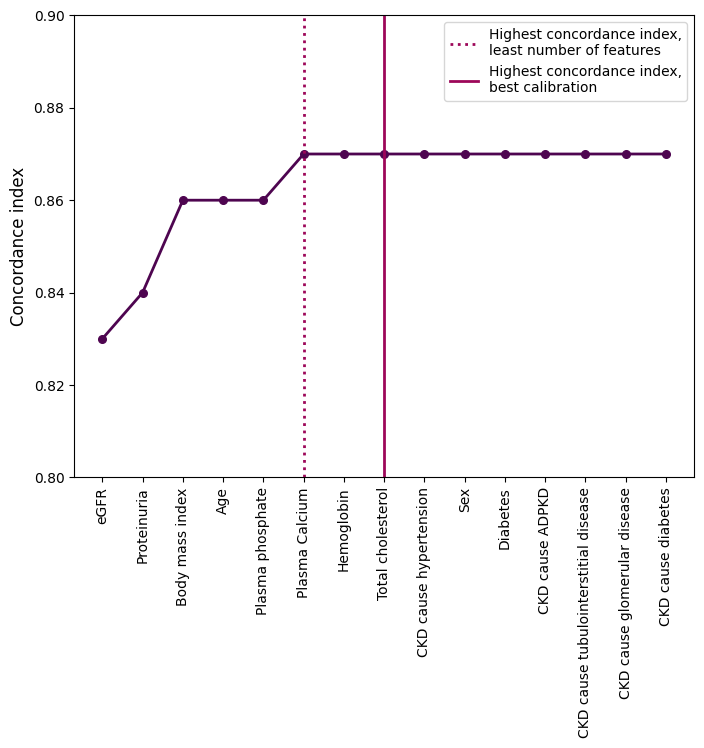

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(feat_names, df_feat_import['c_index'], marker = 'o', markersize = 5.5, color = 'xkcd:plum purple', linewidth = 2.0)
plt.xticks(rotation=90, fontsize = 10)
plt.yticks(fontsize = 10)
plt.ylabel('Concordance index', fontsize = 12)
plt.ylim(0.8, 0.9)
plt.axvline(x=np.argmax(df_feat_import['c_index']), color='xkcd:dark fuchsia', linestyle='dotted', linewidth = 2.0, label = 'Highest concordance index,\nleast number of features')
plt.axvline(x=np.argmax(df_feat_import['c_index'])+2, color='xkcd:dark fuchsia', linestyle='solid', linewidth = 2.0, label = 'Highest concordance index,\nbest calibration')
plt.legend()
plt.savefig("figures/figure_1.pdf", bbox_inches='tight')

plt.show()

In [26]:
# Save the dataframe which figure 1 is based on
df_feat_import.to_csv('raw_results/feature_importance.csv', index=False)